In [1]:
import math

def route_length_nm(coords):
    """
    Compute total great-circle distance (in nautical miles)
    along a route defined by (lon, lat) coordinate pairs.

    Parameters
    ----------
    coords : list of tuple
        Sequence of (longitude, latitude) points along the route.

    Returns
    -------
    float
        Total route length in nautical miles.
    """
    R = 6371.0  # Earth radius in km

    def haversine_km(p1, p2):
        lon1, lat1 = map(math.radians, p1)
        lon2, lat2 = map(math.radians, p2)
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        return 2 * R * math.asin(math.sqrt(a))

    total_km = sum(haversine_km(coords[i], coords[i + 1]) for i in range(len(coords) - 1))
    return total_km / 1.852  # convert km → nautical miles


In [2]:
route = [
    (103.8, 1.3),    # Singapore
    (110.0, 10.0),   # South China Sea waypoint
    (115.0, 20.0),   # Another waypoint
    (121.5, 31.2)    # Shanghai
]

distance_nm = route_length_nm(route)
print(f"Total route length: {distance_nm:.2f} nautical miles")


Total route length: 2065.26 nautical miles


NOW EXECUTINGHE MAIN SCRIPT


/var/folders/rx/k987rdhn4s73d49kst7syjz40000gn/T/ipykernel_46897/3292490652.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_union = land.unary_union  # merge all polygons
/var/folders/rx/k987rdhn4s73d49kst7syjz40000gn/T/ipykernel_46897/3292490652.py:32: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask = vectorized.contains(land_union, LON, LAT)  # True = land


Total water nodes: 1188
optimized route: 
 2225.412054516513
Optimized open-water route length: 2225.41 nautical miles


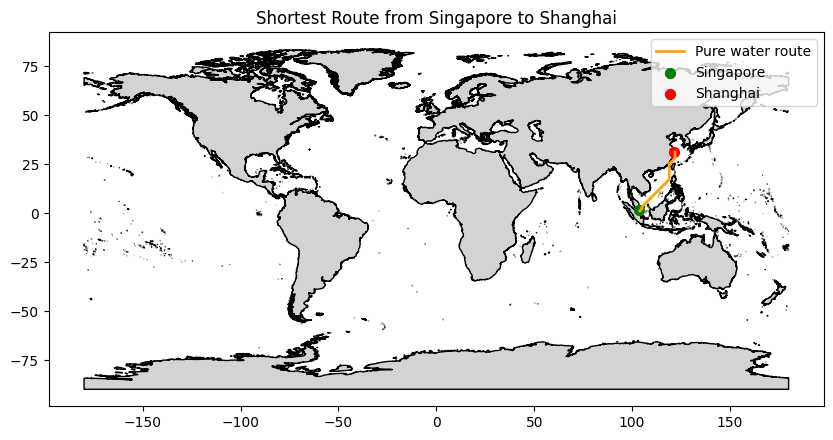

In [4]:
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import rasterio
from shapely import vectorized
from shapely.geometry import Point


print("NOW EXECUTINGHE MAIN SCRIPT")

# --- 1. Load land polygons ---
url = "https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip"
land = gpd.read_file(f"zip+{url}")

# --- 2. Load bathymetry ---
bathy = rasterio.open("data/ETOPO1_Ice_g_geotiff.tif")  # optional for weighting

# --- 3. Define grid region (Southeast Asia, 1° resolution) ---
STEP_SIZE = 1
LON_STEP = STEP_SIZE
LAT_STEP = STEP_SIZE
lons = np.arange(90, 130 + LON_STEP, LON_STEP)
lats = np.arange(-10, 40 + LAT_STEP, LAT_STEP)

start = (103.8, 1.3)   # Singapore
goal = (121.5, 31.2)   # Shanghai

# --- 4. Compute water zones (vectorized, super fast) ---
land_union = land.unary_union  # merge all polygons
LON, LAT = np.meshgrid(lons, lats)
mask = vectorized.contains(land_union, LON, LAT)  # True = land

water_lons = LON[~mask]
water_lats = LAT[~mask]
nodes = list(zip(water_lons, water_lats))
print(f"Total water nodes: {len(nodes)}")

# --- 5. Build simple graph (no bathymetry yet) ---
G_normal = nx.Graph()
node_set = set(nodes)

for lon, lat in nodes:
    for dlon in [-LON_STEP, 0, LON_STEP]:
        for dlat in [-LAT_STEP, 0, LON_STEP]:
            if dlon == 0 and dlat == 0:
                continue
            nlon, nlat = lon + dlon, lat + dlat
            if (nlon, nlat) in node_set:
                dist = np.hypot(dlon, dlat)
                G_normal.add_edge((lon, lat), (nlon, nlat), weight=dist)

# --- 6. Find nearest grid nodes to start and goal ---
def nearest_node(coord):
    return min(nodes, key=lambda n: np.hypot(n[0]-coord[0], n[1]-coord[1]))

start_n = nearest_node(start)
goal_n  = nearest_node(goal)

# --- 7. Compute path --- T
path_normal = nx.shortest_path(G_normal, source=start_n, target=goal_n, weight='weight')

# --- 7b. Compute total route length in nautical miles ---
optimized_route_nm = route_length_nm(path_normal)
print(f"optimized route: \n {optimized_route_nm}")
print(f"Optimized open-water route length: {optimized_route_nm:.2f} nautical miles")
np.savetxt("optimized_route.csv", path_normal, delimiter=",", header="lon,lat", comments="")

# --- 8. Plot ---
fig, ax = plt.subplots(figsize=(10, 8))
land.plot(ax=ax, color="lightgray", edgecolor="black")
ax.plot(*zip(*path_normal), color="orange", linewidth=2, label="Pure water route")
ax.scatter(*start, color="green", s=50, label="Singapore")
ax.scatter(*goal, color="red", s=50, label="Shanghai")
ax.legend()
ax.set_title("Shortest Route from Singapore to Shanghai")
plt.show()